In [1]:
#pwd
#cd ~Desktop/covid_machinations

In [2]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [55]:
# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/scrape/bin/python'

In [4]:
# os, shutil used for copying/moving files
import os
import shutil
# shutil.copyfile('src', 'dst')
# shutil.move

import numpy as np
import pandas as pd
import openpyxl

In [5]:
# This code was used when repeatedly modifying date_checker module
#import importlib
#importlib.import_module('state_country_dicts') #note difference between this and reload
#importlib.reload(dc) #date_checker

In [6]:
# Custom pie_dict module contains only one function (pie) which reduces 
# the number of types into only seven basic categories for creating piecharts
from pie_dict import pie

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.display import Image
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-04-21'

### The following cell determines if the Colorado site has been updated

In [8]:
# outbreaks files are updated on the web once a week usually Wed afternoon
# date_checker is a custom python module that compares the date of the
# last saved outbreak.xlsx file to the date of the outbreak.xlsx
# file on the web
import date_checker as dc

#Returns the date of the latest saved spreadsheet.
previous = dc.get_date()


# compare function outputs a tuple: url link and a date
# and prints the dates of the spreadsheets
names = dc.compare(previous)

latest saved spreadsheet is 2021-04-14
COVID-19 OB Weekly Report 04 21 2021.xlsx
https://covid19.colorado.gov/sites/covid19/files/documents/COVID-19%20OB%20Weekly%20Report%2004%2021%202021.xlsx
Site UPDATED! current date of spreadsheet is 2021-04-21
OK to continue


In [9]:
# Examine the tuple
print (names[0])
print (names[1])

https://covid19.colorado.gov/sites/covid19/files/documents/COVID-19%20OB%20Weekly%20Report%2004%2021%202021.xlsx
2021-04-21 00:00:00


### Colorado Outbreak data

In [10]:
import urllib
import requests
import re

url = 'https://covid19.colorado.gov/data/outbreak-data'

In [11]:
ls

ColoradoOutbreaks.ipynb  covid.ipynb              pie_dict.py*
LICENSE                  covid_data/              state_country_dicts.py
README.md                covid_data_update/       style-notebook.css
Untitled.ipynb           date_checker.py*         style-table.css
__pycache__/             environment.yml          temp.xlsx


In [12]:
ls covid_data_update/

us_2021-04-21.png
us_GA_LA_MS_NM_last_60_days_2021-04-21.png
us_GA_LA_MS_NM_last_90_days_2021-04-21.png
us_rolling_avg_2021-04-21.png
world_2021-04-21.png
world_DE_FR_UK_IN_last_60_days_2021-04-21.png
world_DE_FR_UK_IN_last_90_days_2021-04-21.png
world_rolling_avg_2021-04-21.png


In [13]:
def get_weekly_report(names):
    '''
    Opens the web page and creates a copy of the xlsx file,
    which is then archived in the directory covid_data.
    
    names is the tuple variable created by data_checker.compare()
    the two components of names are: 1) url link and 2)date in string format
    
    returns a dataframe
    '''
    link = names[0]
    response = requests.get(link)
    with open ('temp.xlsx', 'wb') as file:
        file.write(response.content)
    
    # create a permanent copy of the xlsx file in the covid_data directory
    current = names[1]
    current_report = current.strftime('%Y-%m-%d')
    shutil.copyfile('temp.xlsx', f'covid_data/covid_report_{current_report}.xlsx')
    
    df = pd.read_excel('temp.xlsx',sheet_name='Active',engine='openpyxl',parse_dates=['Date reported to public health'])
    return df

In [14]:
df = get_weekly_report(names)
df.shape

(722, 65)

In [15]:
df = df.iloc[:,:16]
df.head(3)

,Setting name,Investigation status,Date outbreak was considered closed:,COVID Setting Type,"If setting type is other, specify","Is this an At Risk Population? (Healthcare, Corrections, Highly Mobile, Schools, Critical Infrastructure)",Colorado county (exposure location),Date reported to public health,Total resident cases,Total staff cases,Total attendee cases,Total resident deaths,Total staff deaths,Total attendee deaths,Total cases,Total deaths
0,10 Barrel,Active,NaN,Bar/Tavern/Brewery,NaN,NaN,Denver,2021-04-02,NaN,6.0,NaN,NaN,NaN,NaN,6,0
1,3STEP Lacrosse,Active,NaN,Youth Sports/Activities,NaN,NaN,Denver,2021-03-27,NaN,5.0,NaN,NaN,NaN,NaN,5,0
2,4th Judicial District Attorney's Office,Active,NaN,Law Enforcement Administration,NaN,Yes,El Paso,2021-03-08,NaN,9.0,NaN,NaN,NaN,NaN,9,0


In [16]:
def polish_report(df):
    '''polish_report removes and reorders columns and assigns shortened names. It also
    creates a datetime index, changes strings to integers and handles NaNs
    Returns: a copy of the original df
    '''
    # eliminate unnecessary columns and re-order columns
    df = df.iloc[:,[-2,0,3,6,7,8,9,10]].copy()
    
    # shorten col names for easier manipulation
    df.columns = ['total','name','type', 'county','date','residents','staff','attendee']
    
    # use the date column as the index
    df.index = df.date
    df.drop('date',axis=1, inplace=True)
    
    # replace nuisance commas
    df.name = df.name.str.replace(',','_')
    
    # fill na with 0 and turn strings to integers
    df = df.fillna(0)
    df['attendee'] = df['attendee'].astype(int) 
    df['staff'] = df['staff'].astype(int) 
    df['residents'] = df['residents'].astype(int)
    
    return df

In [17]:
df = polish_report(df)
# Sanity Check!!!
df.sort_index(ascending=False).head(10)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-04-21,2,Manhattan Middle School,School K-12,Boulder,0,0,2
2021-04-21,5,Penrose St. Francis Health Services- Food and ...,Healthcare - Acute Care Hospital,El Paso,0,5,0
2021-04-21,4,KinderCare Learning Center Oakridge,Child Care Center,Larimer,0,1,3
2021-04-20,3,Dolores County High School,School K-12,Dolores,0,0,3
2021-04-20,5,Die Cut Technologies,Non-Food Manufacturer/Warehouse,Adams,0,5,0
2021-04-20,3,Buena Vista Correctional Complex: April 2021,State Prison,Colorado,3,0,0
2021-04-20,3,Arryved,Office/Indoor Workspace,Boulder,0,3,0
2021-04-20,2,Brush Creek Saloon,Bar/Tavern/Brewery,Eagle,0,2,0
2021-04-20,8,Liberty Tree Academy,School K-12,El Paso,0,2,6


### outbreaks

In [18]:
# this saves four csv files for easy viewing access even on an ipad organized by county,type, total and date
# use of f-string to allow 'day' to be interpreted correctly
df.sort_values(by='county', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-COUNTY-{day}.csv')

df.sort_values(by='type', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-TYPE-{day}.csv')

df.sort_values(by='total', inplace=True,ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-TOTAL-{day}.csv')

df =df.sort_index(ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-DATE-{day}.csv')

# total active
print(f'There are {df.shape[0]} outbreak sites and {df.total.sum()} active cases in Colorado')

There are 722 outbreak sites and 21135 active cases in Colorado


In [20]:
# prompt user to select month (default to current month)
# selecting months in the distant past may yield incorrect values
m = input('Select the month by number (update only recent months):') or names[1].month
y = names[1].year
m = int(m)
print(f'Updating df_month for year {y} and month {m}')

Select the month by number (update only recent months): 


Updating df_month for year 2021 and month 4


In [21]:
# dfy is the df for the current year
dfy = df[df.index.year==y].copy()

In [22]:
# df_month is the df for the selected month
df_month = dfy[dfy.index.month==m].copy()

In [23]:
df_month.reset_index(inplace=True)
df_month = df_month[['total','name','type','county']]

In [24]:
df_month.to_csv(f'./covid_data/covid_2021_{m}.txt')

In [25]:
# get number of sites and total cases for the month
s = df_month.shape[0]
t = df_month.total.sum()
print(f'There were an additional {s} outbreak sites in Colorado this month.')
print (f'These represent a total of {t} new cases.')

There were an additional 388 outbreak sites in Colorado this month.
These represent a total of 1881 new cases.


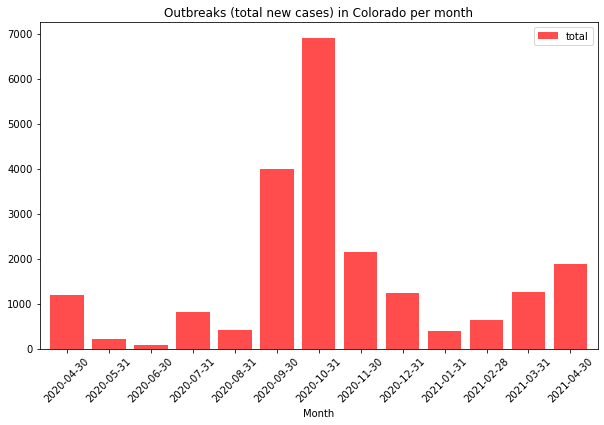

In [26]:
dfm = df.resample('M').sum()
dfm['Month'] = dfm.index.date
dfm

dfm[['Month','total']].plot.bar(figsize=(10,6), \
                                x='Month',rot=45, width=.8, \
                                color="red",alpha=.7,\
                                title="Outbreaks (total new cases) in Colorado per month")
plt.savefig(f'./covid_data_update/outbreaks-per-month-{day}.png');

In [27]:
dfm.sort_index(ascending = False)

,total,residents,staff,attendee,Month
date,,,,,
2021-04-30,1881,100,1074,707,2021-04-30
2021-03-31,1257,141,611,505,2021-03-31
2021-02-28,629,23,309,297,2021-02-28
2021-01-31,383,25,150,208,2021-01-31
2020-12-31,1230,353,638,239,2020-12-31
2020-11-30,2138,538,1402,198,2020-11-30
2020-10-31,6902,2154,911,3837,2020-10-31
2020-09-30,3996,0,522,3474,2020-09-30
2020-08-31,415,0,411,4,2020-08-31


In [28]:
# list all active cases in Boulder County
boulder = df[df.county=='Boulder']
bc = boulder.total.sum()
print(f'There are {bc} active cases in Boulder County')

There are 3744 active cases in Boulder County


In [29]:
boulder = boulder.sort_index(ascending=False)
boulder.to_csv(f'./covid_data_update/boulder-{day}.csv')
boulder

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-04-21,2,Manhattan Middle School,School K-12,Boulder,0,0,2
2021-04-20,3,Jax Fish House & Oyster Bar- Boulder,Restaurant - Sit Down,Boulder,0,3,0
2021-04-20,3,Arryved,Office/Indoor Workspace,Boulder,0,3,0
2021-04-20,3,Legacy of Lafayette (230322),Healthcare - Assisted Living,Boulder,2,1,0
2021-04-19,4,Skyline High School: April 2021,School K-12,Boulder,0,0,4
2021-04-19,3,South Main Station,Other,Boulder,0,3,0
2021-04-19,2,Brookdale Boulder Creek (2303QF): April 2021,Healthcare - Assisted Living,Boulder,0,2,0
2021-04-19,4,Loxo Oncology Construction Project,Construction Site,Boulder,0,4,0
2021-04-16,4,Mapleton Early Childhood Center,Child Care Center,Boulder,0,0,4


### Create Pie Chart

In [30]:
# total number of active cases
s = df.total.sum()
s

21135

In [31]:
# list of major types by percent of total
df_percent = df.groupby('type').total.sum()/s
print (f'These represent {df_percent[df_percent > .01].sum()*100:.0f}% of all outbreak cases')
df_percent[df_percent > .01]

These represent 89% of all outbreak cases


type
College/University                 0.370050
Construction Company/Contractor    0.016844
Distribution Center/Business       0.012491
Food Manufacturing/Packaging       0.019115
Homeless Shelter                   0.019683
Jail                               0.165082
Materials Supplier                 0.011119
Office/Indoor Workspace            0.034871
Other                              0.027301
Religious Facility                 0.010646
Restaurant - Fast Food             0.011923
Retailer                           0.035533
School K-12                        0.090135
State Prison                       0.061651
Name: total, dtype: float64

In [32]:
# custom function from pie_dict 
from pie_dict import pie

In [33]:
df_pie = pie (df)
df_pie.head()
pie_list = np.array(['College/University', 'Jail/Prison', 'Other',
       'Office/Mfg/Dist/Construction', 'Healthcare', 'Resturant/Retail',
       'Day Care/School'], dtype=object)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-04-21,5,Penrose St. Francis Health Services- Food and ...,Healthcare,El Paso,0,5,0
2021-04-21,2,Manhattan Middle School,Day Care/School,Boulder,0,0,2
2021-04-21,4,KinderCare Learning Center Oakridge,Day Care/School,Larimer,0,1,3
2021-04-20,3,Help & Hope Center,Other,Douglas,0,3,0
2021-04-20,2,Brush Creek Saloon,Resturant/Retail,Eagle,0,2,0


In [34]:
'''test = df.type.unique()
test = np.append(test,['Social Gathering','Travel'])
len(test)
'''

"test = df.type.unique()\ntest = np.append(test,['Social Gathering','Travel'])\nlen(test)\n"

In [35]:
df.type.unique()

array(['Healthcare', 'Day Care/School', 'Other', 'Resturant/Retail',
       'Office/Mfg/Dist/Construction', 'Jail/Prison',
       'College/University'], dtype=object)

In [36]:
test = df.type.unique()
if len(test) != 7:
    more_types = [item for item in test if item not in pie_list]
    df.type = df.type.replace(dict.fromkeys(more_types, 'Other'))
    print(f'{more_types} were added to the category: Other')
else:
    print('No new types were added to the category: Other')

No new types were added to the category: Other


In [37]:
df.total = df.total.astype(int)

p = df.groupby('type').total.sum()
print (p)
total_cases = p.sum()
total_cases

type
College/University              7821
Day Care/School                 2225
Healthcare                       621
Jail/Prison                     4845
Office/Mfg/Dist/Construction    2339
Other                           1821
Resturant/Retail                1463
Name: total, dtype: int64


21135

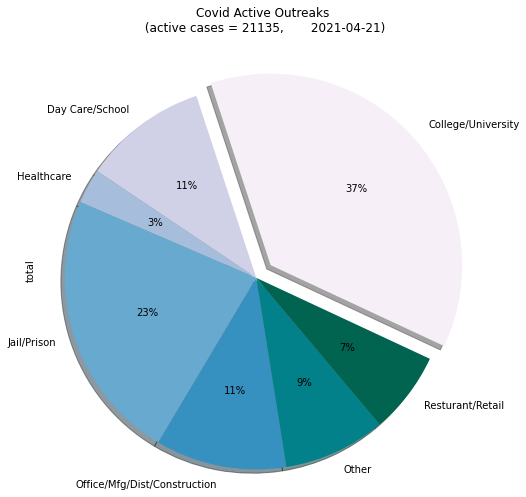

In [38]:
# creates a pie chart of the current total active cases
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (.1,0,0,0,0,0,0)

p.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%',
        shadow=True, colors=my_colors,startangle=-25);
plt.title(f'Covid Active Outreaks\n (active cases = {total_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'./covid_data_update/outbreaks-piechart-{day}.png');

In [39]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

### Change directory

In [45]:
cd covid_data_update

/Users/edwardterrell/Desktop/covid_machinations/covid_data_update


In [46]:
!ls

boulder-2021-04-21.csv
outbreaks-COUNTY-2021-04-21.csv
outbreaks-DATE-2021-04-21.csv
outbreaks-TOTAL-2021-04-21.csv
outbreaks-TYPE-2021-04-21.csv
outbreaks-per-month-2021-04-21.png
outbreaks-piechart-2021-04-21.png
us_2021-04-21.png
us_GA_LA_MS_NM_last_60_days_2021-04-21.png
us_GA_LA_MS_NM_last_90_days_2021-04-21.png
us_rolling_avg_2021-04-21.png
world_2021-04-21.png
world_DE_FR_UK_IN_last_60_days_2021-04-21.png
world_DE_FR_UK_IN_last_90_days_2021-04-21.png
world_rolling_avg_2021-04-21.png


In [47]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations/covid_data_update'

In [48]:
# Gathering summary statistics for a pie chart of current month
# create datetime and integers types 
this_month = pd.read_csv(f'outbreaks-DATE-{day}.csv')
this_month.date = pd.to_datetime(this_month.date)
this_month.total = this_month.total.astype(int)

# apply custom pie function and set filter to current month
this_month = pie(this_month)
apr = this_month[this_month.date > '2021-03-31'].copy()

In [49]:
apr = apr.groupby('type').total.sum()
this_month_cases = apr.sum()
apr

type
College/University               26
Day Care/School                 744
Healthcare                      180
Jail/Prison                      71
Office/Mfg/Dist/Construction    307
Other                           301
Resturant/Retail                252
Name: total, dtype: int64

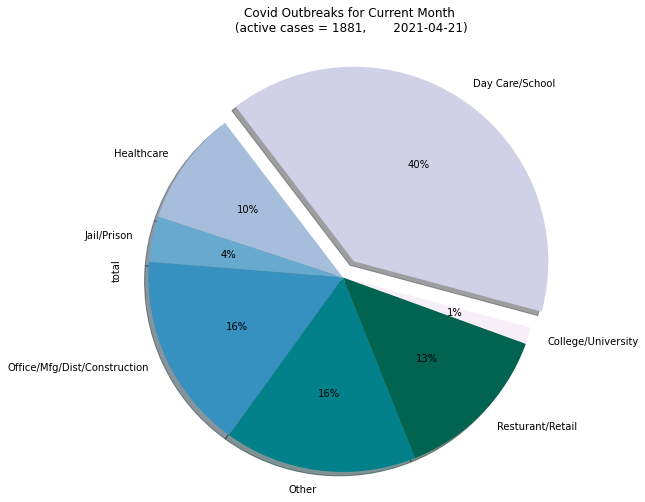

In [50]:
# creates a pie chart of the current month
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (0,.1,0,0,0,0,0)

apr.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%', 
             shadow=True, colors=my_colors,startangle=-20)

plt.title(f'Covid Outbreaks for Current Month\n (active cases = {this_month_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'this_month_outbreaks-piechart-{day}.png');

### Displays all updated graphs files including those from covid.ipynb

In [51]:
!ls -t1 | head -n 20 | grep -ve '^bolder' -ve 'png$' -ve 'xlsx$' > covid_text
!ls *.png > flist_of_covid_png 

# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

In [52]:
png_list

['outbreaks-per-month-2021-04-21.png',
 'outbreaks-piechart-2021-04-21.png',
 'this_month_outbreaks-piechart-2021-04-21.png',
 'us_2021-04-21.png',
 'us_GA_LA_MS_NM_last_60_days_2021-04-21.png',
 'us_GA_LA_MS_NM_last_90_days_2021-04-21.png',
 'us_rolling_avg_2021-04-21.png',
 'world_2021-04-21.png',
 'world_DE_FR_UK_IN_last_60_days_2021-04-21.png',
 'world_DE_FR_UK_IN_last_90_days_2021-04-21.png',
 'world_rolling_avg_2021-04-21.png']

In [53]:
from IPython.display import Image

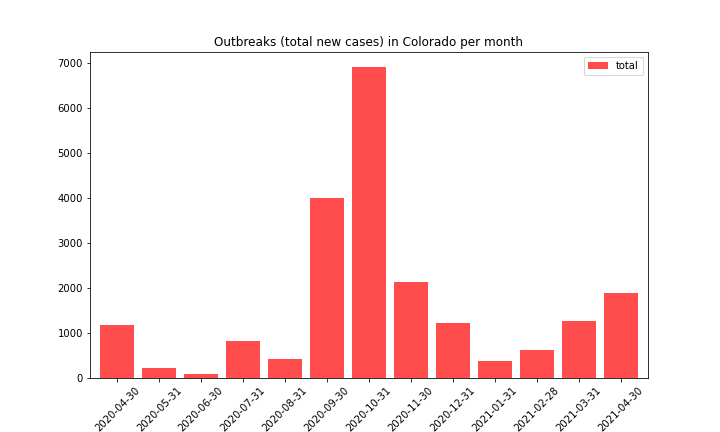

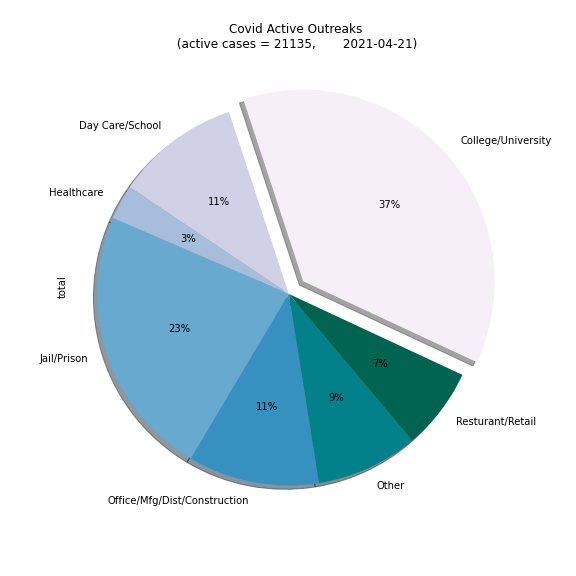

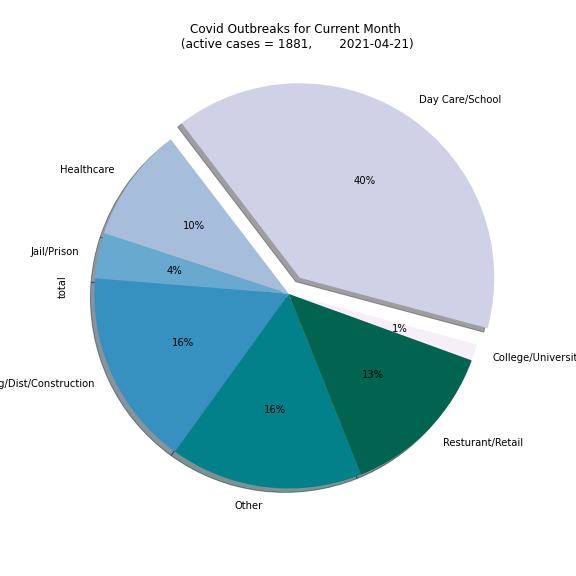

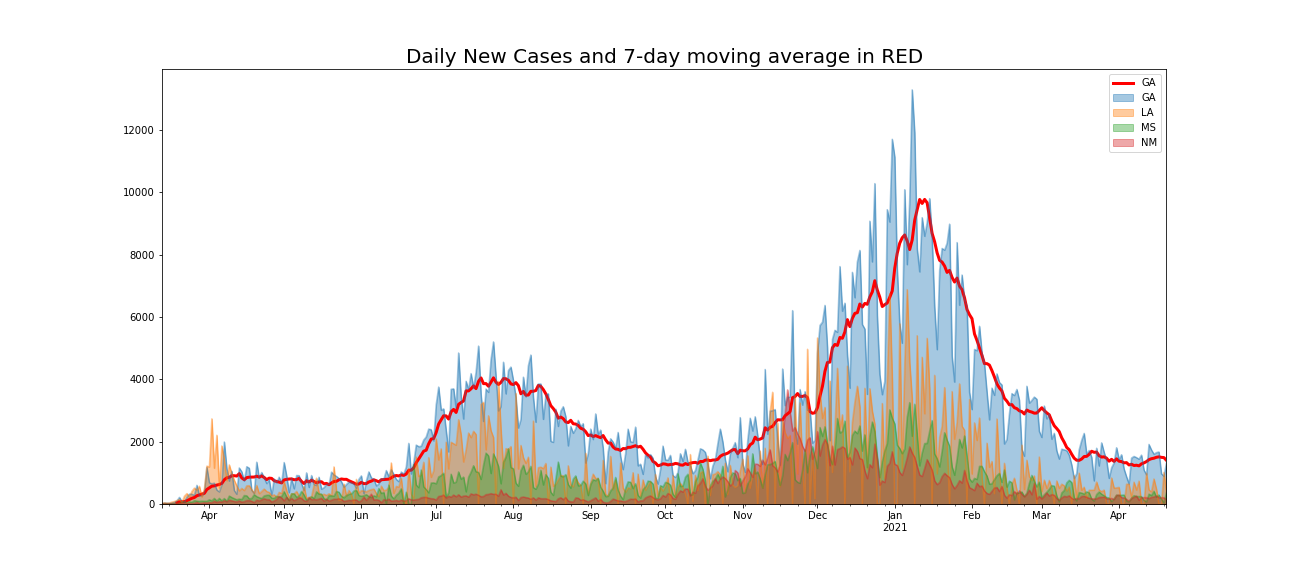

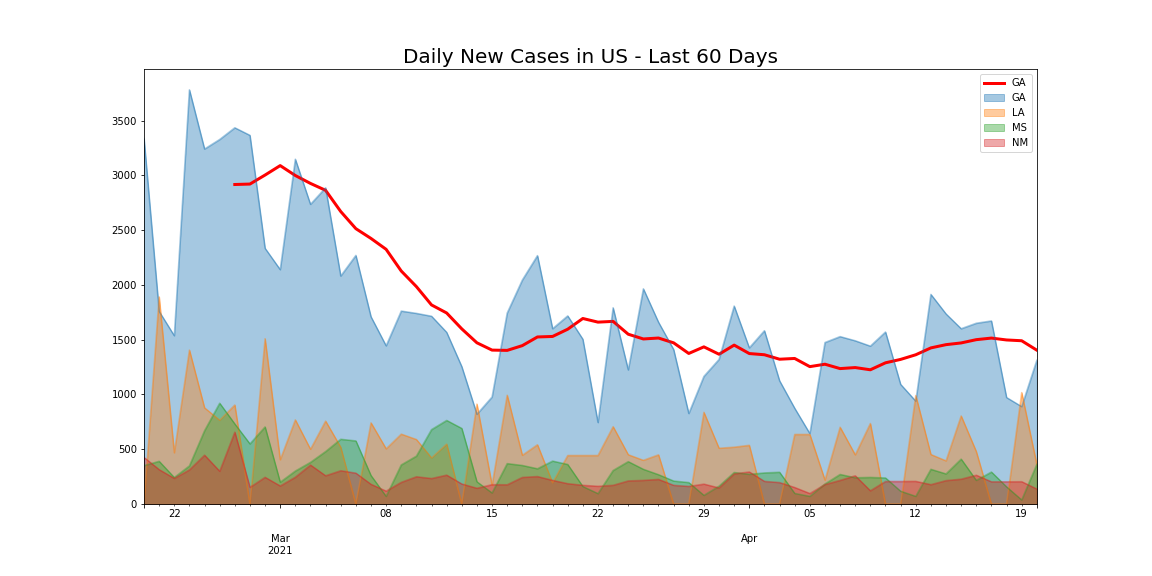

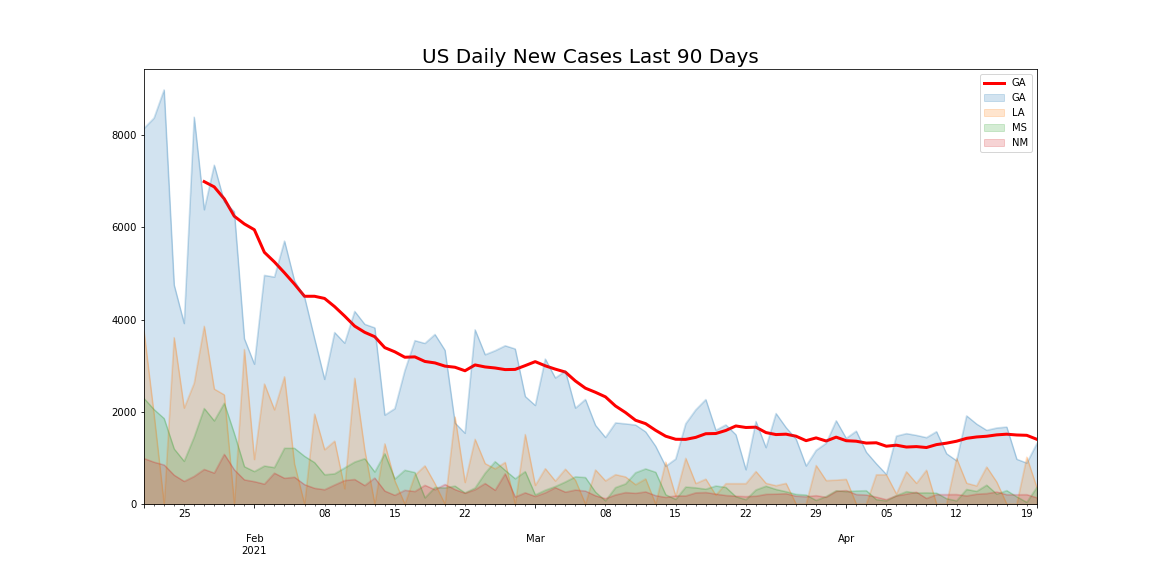

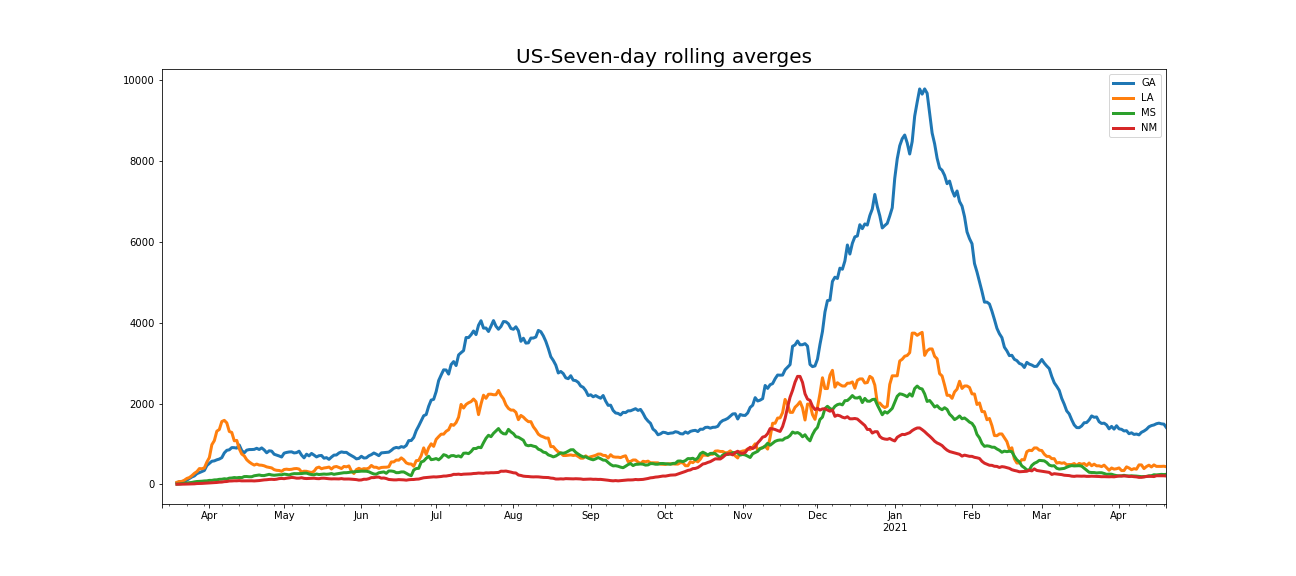

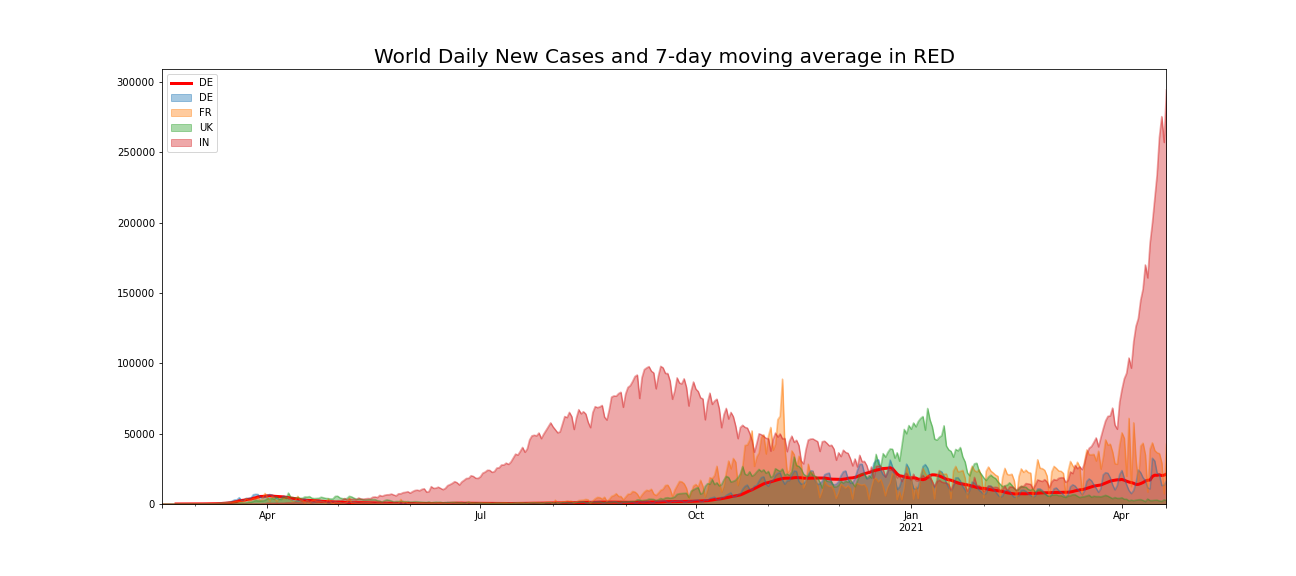

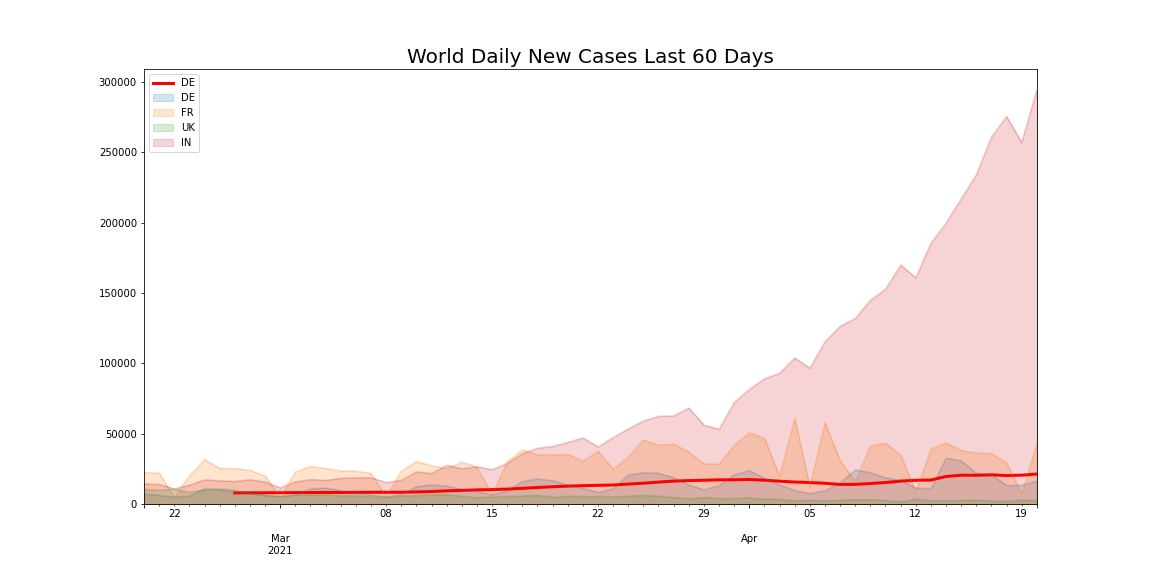

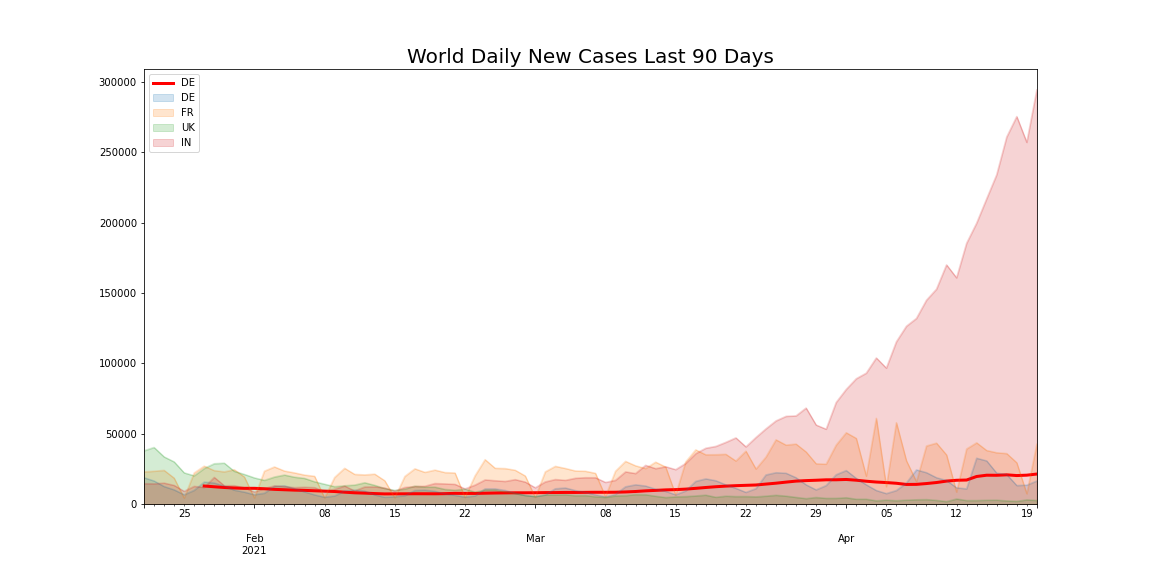

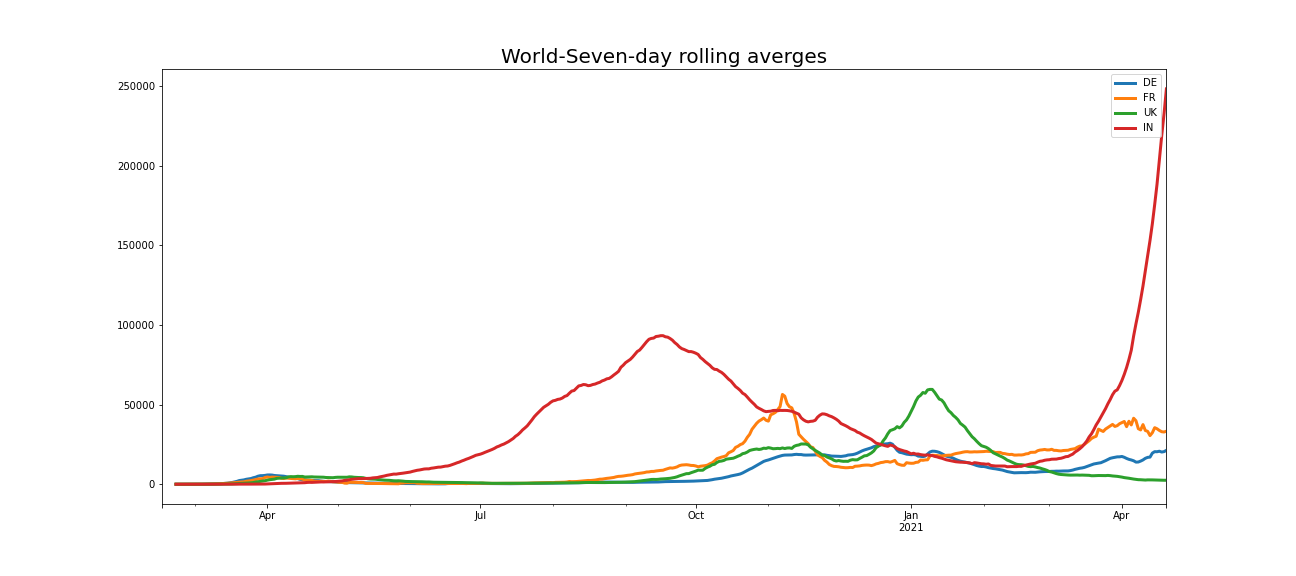

In [54]:
for file in png_list:    
    local = Image(file)
    local
    
# These were helper files and are not needed any longer
!rm -f covid_text
!rm -f flist_of_covid_png
!rm -f temp.xlsx
